In [1]:
from IPython.display import HTML, Image, Code 
import os
import datetime
import pandas as pd
import numpy as np
import colorlover as cl
from pathlib import Path
import ipywidgets as widgets
from collections import Counter
import warnings
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [11]:
import keras
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dropout, Dense

In [4]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
%matplotlib inline

The following cell will hide raw code for easier reading. 

In [ ]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
*The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

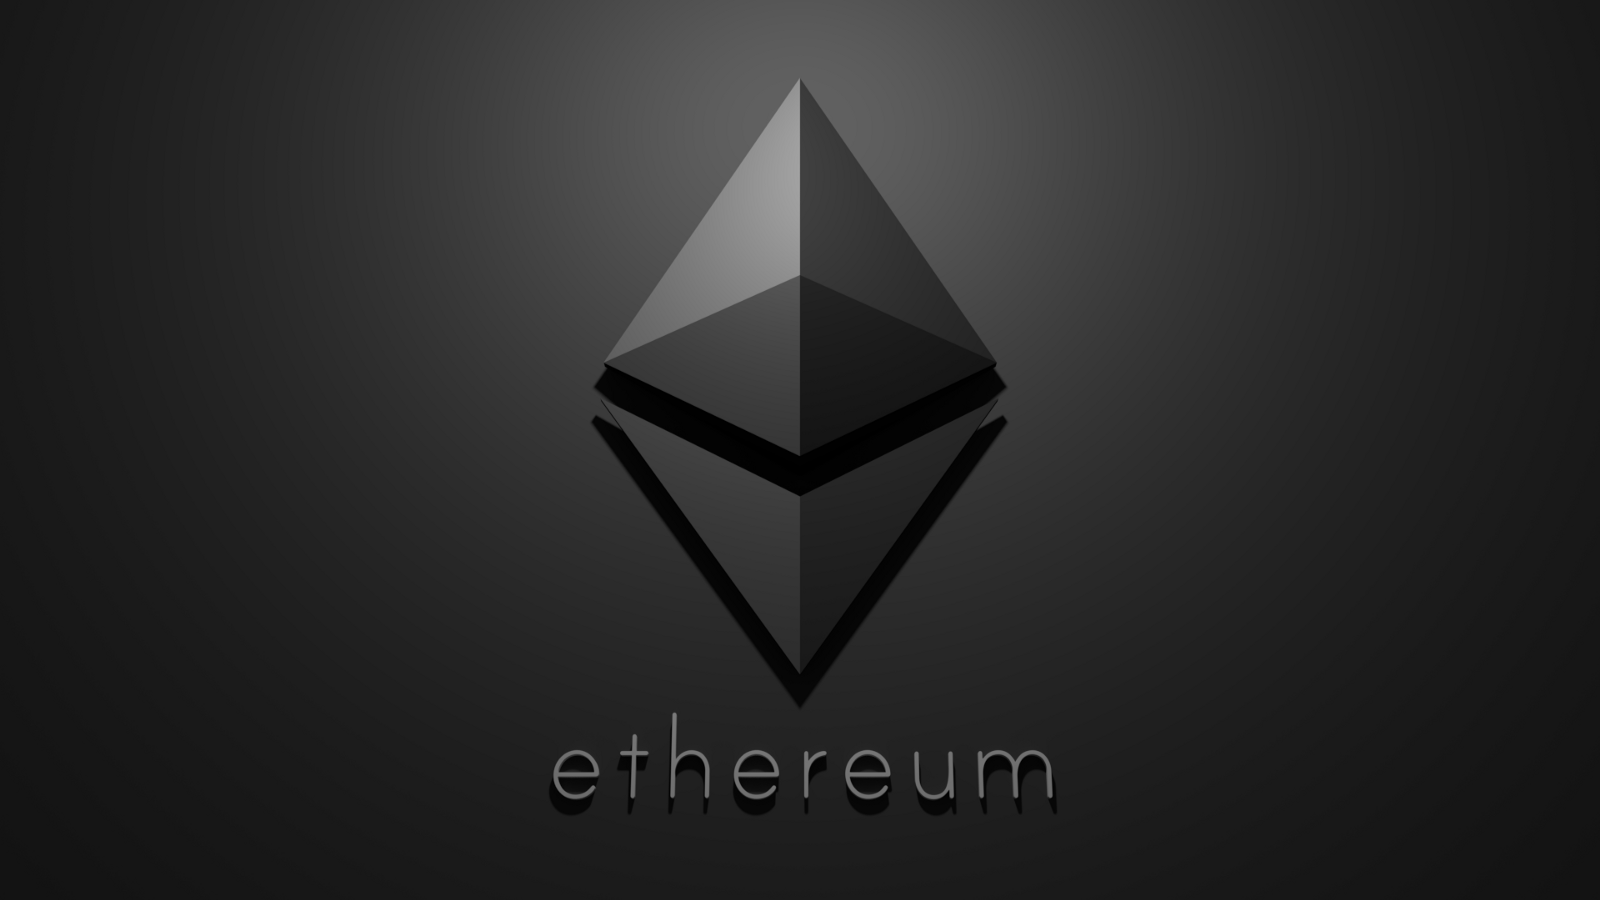

In [13]:
ethereum_image = Path.cwd().joinpath("images/ethereum.png")
Image(filename = str(ethereum_image))

#               Ethereum Forecasting

### Project Overview 

This is still an ongoing project, so some parts are unfinished or unpolished, and will become increasingly finished and polished as I push updates. 

This focus of this project to build forecasting models for Ethereum, both on:<br><br>
    1) price using various regression and time series analysis models, and <br>
    2) whether price would rise or fall in the next hour using machine learning model (and eventually neural nets).  

Regression, classification, and neural net models are still being built out.

The influence of the use case on the ultimate design here is one of my favorite parts of this project. While working with time-series data is a welcome challenge and the feature engineering is intriguing, the most interesting part has been building something with a specific ‘customer’ in mind. For this project, I'm working with a friend who does some casual day trading with cryptocurrencies. I had to build models that were readable and useable for him, and the data had to be readily available.  <br>

For example, the trends data was mostly used to see if information about how searched something was had any informative value for the model. <br>

But, there’s a two week delay on Google Trends data, so this information isn’t useful in a production setting. But if trend data like that had informative value for the model, there are certain proxies or estimators  available that I would explore with my friend. <br>

Having to think through problems like this gives me a better sense of how these models have to operate in production and makes me a better data scientist.  

### Data Import

In [3]:
data_import_code = Path.cwd().joinpath("python_code/api_call.py")
Code(filename = str(data_import_code))

import time
import requests
import pandas as pd

#Intializing the database

url = 'https://min-api.cryptocompare.com/data/histohour?fsym=ETH&tsym=USD&limit=24'
initial_response = requests.post(url)
initial_data = initial_response.json()['Data']
initial_data.reverse()
master_df = pd.DataFrame(initial_data)
master_df = master_df.set_index('time')

start_time_count = int(master_df.index[0])
end_time_count = 1488067199
round_count = 0
# 1488067200 in the unix time for Februrary 26, 2017 at 12am UTC
# This will form our data endpoint

while start_time_count > end_time_count:

    url_temp = url = 'https://min-api.cryptocompare.com/data/histohour?fsym=ETH&tsym=USD&limit=24&toTs={}'.format(start_time_count)

    temp_response = requests.post(url_temp)
    temp_data = temp_response.json()['Data']
    temp_data.reverse()
    temp_df = pd.DataFrame(temp_data)
    temp_df = temp_df.set_index('time')

    master_df = master_df.append(temp_df)
    start_time_count -= 86400
    round_count += 1
    if round_count%500 is True:
        print(round_count)
        time.sleep(5)
        continue
    else:
        time.sleep(5)
        continue
    # always be careful about rate limits. The limit is closer to 3 seconds, but doesn't hurt to be safe when you can afford to be

# writing the mostly un-touched data to csv for later ETL

master_df.to_csv('eth_hourly_data.csv', mode = 'w+')

#End

## Datasets & Features
 
Cryptocurrencies trade 24/7, unlike most other financial instruments, so the data is an uninterrupted look at the past 18 months of Ethereum prices. <br>

One of the challenges of cryptocurrency data is that it can be difficult to tie it to more standard market indicators (commodity prices like gold or oil or market averages like stock indexes or bond yields) because of its 24/7 trading nature. Given more time, I would likely engineer a daily and/or weekly dataset and then interpolate missing dates (weekends and holidays) for these more traditional market indicators. I began but did not get to finish that process, and the amount of what is essentially educated guesswork for night and weekend hours required to bring something like gold price down to an hourly level presented problems od data fidelity. <br>

I primarily used hourly data pulled from the CryptoCompare on Ethereum and Bitcoin prices. Originally the data looked like this:

In [20]:
eth_original = pd.read_csv('data/eth_hourly_data.csv')
eth_original = eth_original[::-1]
eth_original[10000:10003]

,time,close,high,low,open,volumefrom,volumeto
4424,1522623600,378.85,380.67,376.47,377.38,10478.48,3967247.72
4423,1522627200,384.06,387.13,375.80,378.85,31380.29,11997320.40
4422,1522630800,380.55,386.11,380.26,384.06,17287.19,6635075.44


In [21]:
eth_original['time'] = eth_original['time'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
eth_original.set_index(eth_original.time, drop=True, inplace=True)
eth_original.drop(columns=['time'], inplace=True)

In [25]:
# Add data

time_stamps = round(len(eth_original)/168)
tick_dates_eth = [0]
tick_labels_eth = [eth_original.index[0][:10]]
high = [round(np.average(eth_original['high'][:168]), 2)]
low = [round(np.average(eth_original['low'][:168]), 2)]
close = [round(np.average(eth_original['close'][:168]), 2)]
start_value = 0

for i in range(1, time_stamps):
    index_value = round((start_value + 168))
    tick_dates_eth.append(index_value)
    tick_labels_eth.append(eth_original.index[index_value][:10])
    high.append(round(np.max(eth_original['high'][start_value: index_value]), 2))
    low.append(round(np.min(eth_original['low'][start_value: index_value]), 2))
    close.append(round(np.average(eth_original['close'][start_value: index_value]), 2))
#     print('Start is ' + str(start_value))
#     print('Index is ' + str(index_value))
    start_value += 168



# Create and style traces
high_trace = go.Scatter(
    x = tick_labels_eth,
    y = high,
    name = 'Weekly High',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,
        dash = 'dash')
)
low_trace = go.Scatter(
    x = tick_labels_eth,
    y = low,
    name = 'Weekly Low',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 2,
        dash = 'dot')
)
price_trace = go.Scatter(
    x = tick_labels_eth,
    y = close,
    name = 'Weekly Avg. Price',
    line = dict(
        color = ('rgb(128, 255, 0)'),
        width = 2,
        dash = 'solid')
)

price_line_data = [high_trace, low_trace, price_trace]

# Edit the layout
price_line_layout = dict(title = 'Average, High, and Low Prices for Ethereum',
                      xaxis = dict(title = 'Time'),
                      yaxis = dict(title = 'USD - $'),
                          )

price_line_fig = dict(data=price_line_data, layout=price_line_layout)
plotly.offline.iplot(price_line_fig, validate=False, filename='price_line_fig')

But ultimately, I engineered other features based upon these values. I was looking to capture the directionality and momentum of change. One of the transformations I used to do that was a lag-function to allow look-backs on a given column over a given series of time.

In [232]:
hour_change_func_code = Path.cwd().joinpath("code_snippets/hour_change_function.py")
Code(filename = str(hour_change_func_code))

# Lagging data function

def hour_change(shift, dataframe, shift_on):
    shift_column_name = '{}-hour-{}-shift'.format(shift, shift_on)
    change_column_name = '{}-hour-{}-change'.format(shift, shift_on)

    dataframe[shift_column_name] = np.nan
    dataframe[shift_column_name] = dataframe[shift_on].shift(shift)

    dataframe.fillna(method='bfill', inplace=True)

    dataframe[change_column_name] = dataframe[shift_on] - dataframe[shift_column_name]
    dataframe.drop(columns=[shift_column_name], inplace=True)

    return dataframe

# Function in action

shifts = [1, 2, 3, 4, 6, 8, 10, 12]
for x in shifts:
    eth_data = hour_change(x, eth_price_data, 'close')

That function allows the following columns to be easily produced.

In [8]:
eth_engineered = pd.read_csv('data/ml_class_data_ver1.csv')
eth_engineered.set_index(eth_engineered.time, drop=True, inplace=True)
eth_engineered.drop(columns=['time', 'Unnamed: 0', '1-hour-close-change-btc', '2-hour-close-change-btc', 
                            '3-hour-close-change-btc', '4-hour-close-change-btc', '6-hour-close-change-btc', 
                            '8-hour-close-change-btc', '10-hour-close-change-btc', '12-hour-close-change-btc', 
                            'volume-btc', 'range-btc', '3-hour-close-change-eth'], inplace=True)
# eth_engineered.columns = ['time', ]
eth_engineered[10000:10003]

,1-hour-close-change-eth,2-hour-close-change-eth,4-hour-close-change-eth,6-hour-close-change-eth,8-hour-close-change-eth,10-hour-close-change-eth,12-hour-close-change-eth,sign_change,volume-eth,range-eth
time,,,,,,,,,,
2018-04-18 16:00:00,6.36,7.38,-1.02,1.99,2.09,0.54,9.82,0,0.049962,7.11
2018-04-18 17:00:00,-1.45,4.91,-0.49,-1.75,0.32,-0.87,6.43,1,0.038676,3.54
2018-04-18 18:00:00,0.88,-0.57,6.81,-1.59,1.42,1.52,-0.03,1,0.018174,2.12


### Google Trends Data
I chose this data because: <br>
- It's tracked on a 24/7 hourly basis <br>
- It can be a proxy for 'news-worthy' events <br>
- It can be a gauge of public awareness / investor interest <br>

<b> BUT: </b> <br>
- There's a two week lag on Google Trends data, which presents a use-case challenge <br>
- and more features do not necessarily lead to improved accuracy

In [89]:
trend_data = pd.read_csv('data/google_trends_data_eth.csv')
trend_data_2 = pd.read_csv('data/google_trends_data_btc.csv')
trend_data_combo = trend_data.merge(trend_data_2)
trend_data_combo.set_index(trend_data_combo.date, drop = True, inplace = True)
trend_data_combo.drop(columns = ['isPartial', 'buy ethereum', 'date'], inplace = True)
trend_data_combo[10000:10003]

,Ethereum,eth,bitcoin,blockchain,btc,crypto,cryptocurrency
date,,,,,,,
2018-04-05 10:00:00,7,5,70,11,77,49,44
2018-04-05 11:00:00,7,5,74,10,74,50,52
2018-04-05 12:00:00,7,5,82,10,79,54,64


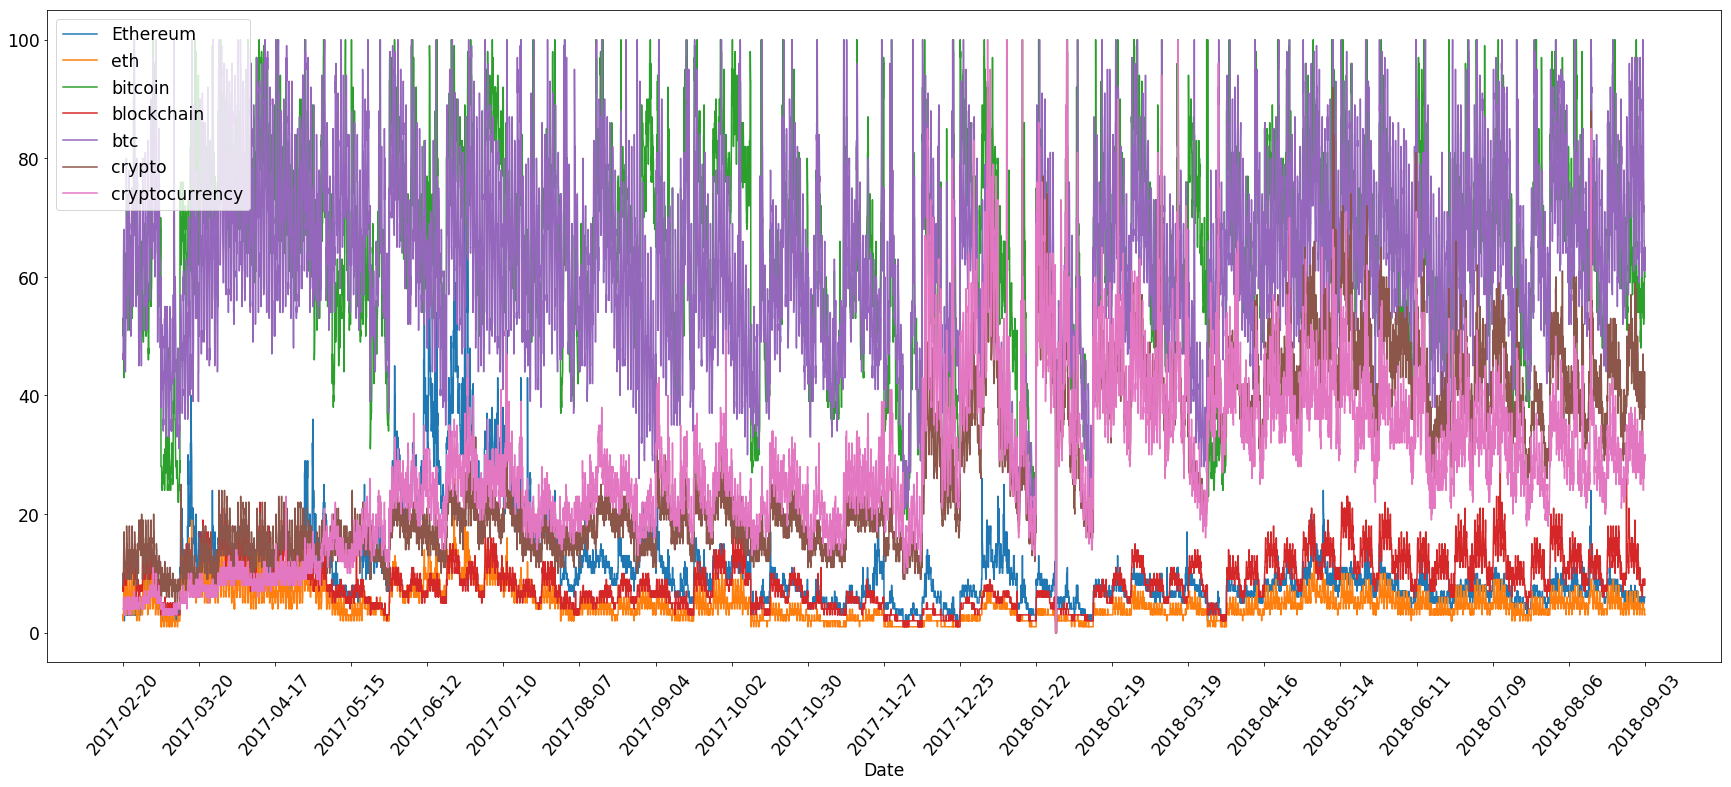

In [77]:
tick_jump = len(trend_data_combo)/20
ticks = [0]
labels = [trend_data_combo.index[0][:10]]
for i in range(1, 21):
    index_value = round((tick_jump * i) - 1)
    ticks.append(index_value)
    labels.append(trend_data_combo.index[index_value][:10])

trend_data_combo.plot(figsize = (30,12), fontsize = "xx-large")
plt.legend(loc = 2, fontsize = 'xx-large')
plt.xlabel("Date", fontsize = 'xx-large')
plt.xticks(ticks, labels, rotation = 50)
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c3b6d6320>,
      dtype=object)

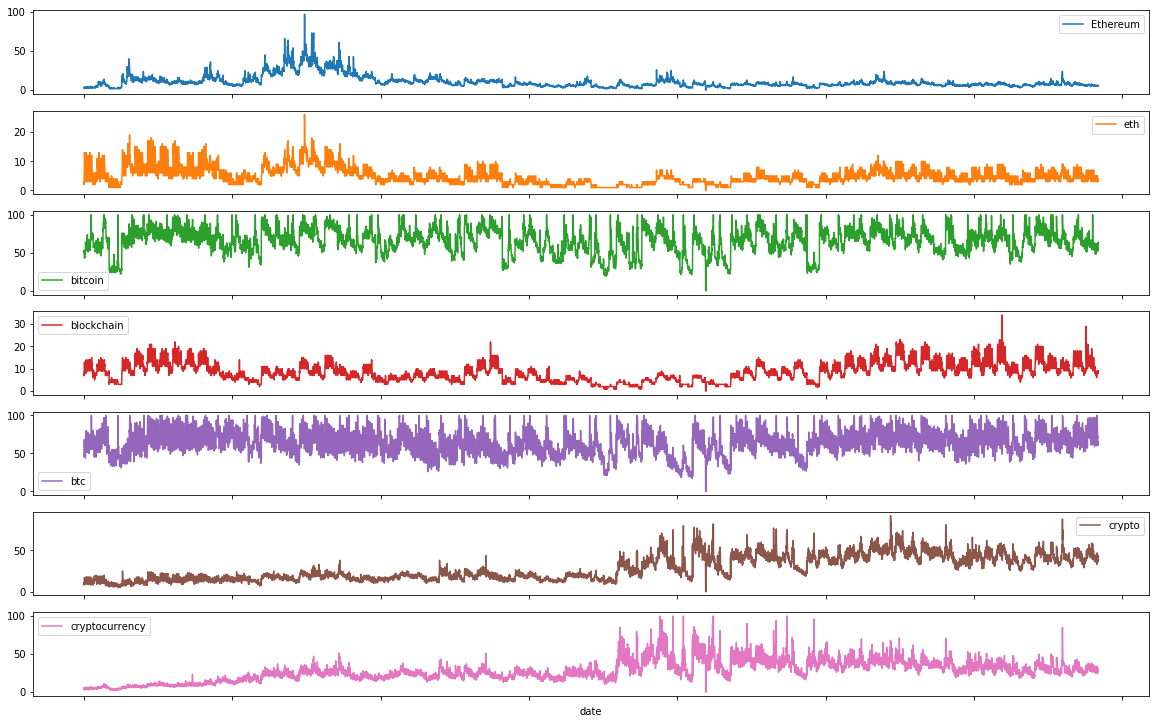

In [92]:
trend_data_combo.plot(subplots=True, figsize = [20, 14])
# plt.xticks(ticks, labels, rotation = 50)

## Regression Modeling

Regression methods seek to predict a continuous value, and this often makes them more challenging than their classification counterparts. Here, my regression models seek to predict the future price.

#### FBProphet - Additive Modeling

Ultimately, while I had hourly data going back 18 months, my best model performances occured when I fed the model smaller ranges of data, likely because it was less swayed by past trends that no longer represented the state of the market. This is the reasoning by creating lookback 'windows'. <br> 
My best FBProhpet models had a lookback between 2-4 weeks. The model here looks back just shy of three weeks and then makes predictions (with confidence intervals) hourly for the next 24 hours after the end of the data. You'll notice the confidence intervals widen swiftly, as the model becomes less certain.  

In [208]:
from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler

In [214]:
data = pd.read_csv('data/eth_hourly_data.csv')
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True, drop=True)
data['ds'] = data['time'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%dT%H:%M:%S'))
data['y'] = data['close']
data = data[::-1]
data.reset_index(inplace = True, drop = True)
data.drop(columns=['time', 'high', 'low', 'open', 'close', 'volumeto', 'volumefrom'], inplace=True)

In [219]:
proph4 = Prophet(interval_width=.95)
proph4.fit(data.iloc[-500:])
future4 = proph4.make_future_dataframe(freq="H", periods=24)
forecast4 = proph4.predict(future4)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


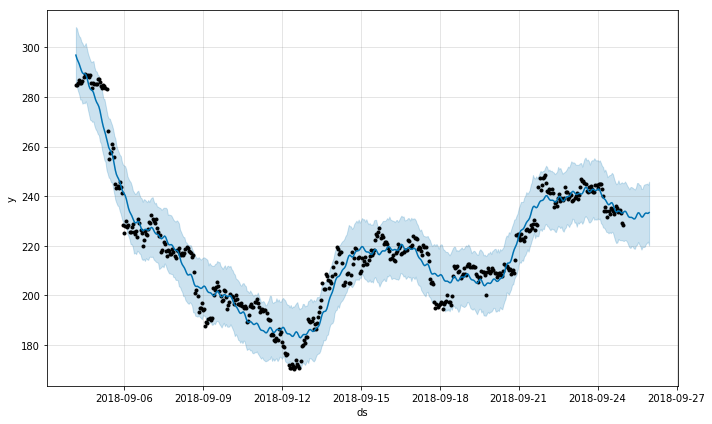

In [220]:
fig1_4 = proph4.plot(forecast4)

One of the most interesting features of FBProphet is that ability to visualize the various component trends that are influencing your data. Below we can see the general price trend over the course of the entire period, daily, and weekly.

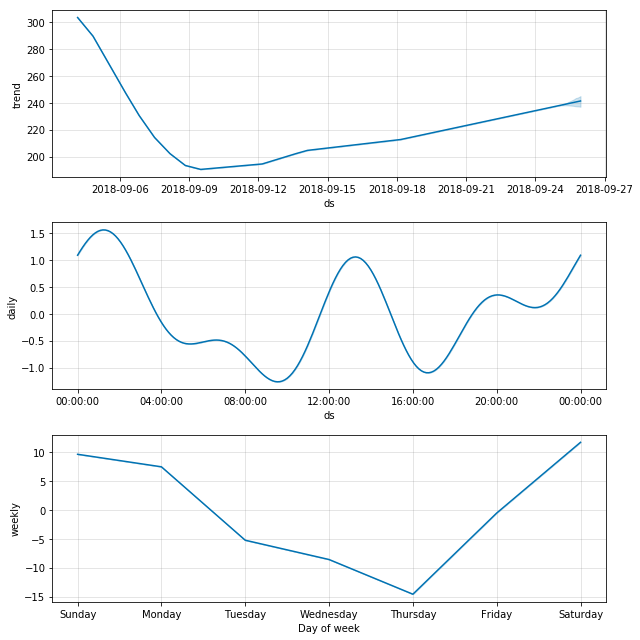

In [221]:
fig2_4 = proph4.plot_components(forecast4)

In [218]:
prediction_table4 = pd.DataFrame()
prediction_table4['time'] = forecast4.ds.iloc[-48:]
prediction_table4['predicted_close'] = round(forecast4.yhat.iloc[-48:], 2)
prediction_table4.head()

,time,predicted_close
312,2018-09-24 00:00:00,240.21
313,2018-09-24 01:00:00,240.34
314,2018-09-24 02:00:00,239.92
315,2018-09-24 03:00:00,239.18
316,2018-09-24 04:00:00,238.44


## Classification Modeling
### Machine Learning Methods
As opposed to regression, classification attempts to predict a discrete (categorical) value. The classication here is binary and looks to predict whether the price will rise or fall in the next hour. <br><br>
I suspect that the multicollinearity between many of these features is adding (bias) noise to the model. My educated guess is that because of this, the explicit regularization applied by the logistic regression model explains its outperforming other models. <br><br>
I built out a quick way of running a complete gridsearch on a classification model with just a few tweeks.

In [26]:
rf_example_code = Path.cwd().joinpath("code_snippets/random_forest_example.py")
Code(filename = str(rf_example_code))

# Creating dict to hold data with and without trend data for streamlined testing

training_sets = {'train': [target_train, features_train, target_val, features_val],
                'train_with_trend' : [target_with_trends_train, features_with_trends_train,
                                      target_with_trends_val, features_with_trends_val]}

# Building function to gridsearch multiple datasets and return relevent results

def test_classifiers(data, grid):
    results_dict = {}

    for data_set, splits in data.items():
        grid.fit(splits[1], splits[0])
        results_dict[data_set + ' results'] = [grid.best_score_, grid.best_params_, grid.score(splits[1], splits[0]), grid.score(splits[3], splits[2])]

    return results_dict

# Creating and Running GridSearch on Random Forest Model

from sklearn.ensemble import RandomForestClassifier

rft_param_grid = {'randomforestclassifier__n_estimators': [250, 350, 450],
                'randomforestclassifier__max_depth': [2, 6, 10, 14, 18, 22]}

rft_pipe = make_pipeline(RandomForestClassifier())

rft_grid = GridSearchCV(rft_pipe, rft_param_grid, scoring = "accuracy")

rft_results = test_classifiers(training_sets, rft_grid)

rft_results

In [28]:
ml_results_data = pd.read_csv('data/model_performance_data.csv')
ml_results_data.set_index(ml_results_data['Model Type'], drop=True, inplace=True)
ml_results_data.drop(columns=['Unnamed: 0', 'Model Type'], inplace=True)

Results were pretty muted across models.

In [29]:
header_values = [ml_results_data.index.name]
for i in range(len(ml_results_data.columns)):
    header_values.append(ml_results_data.columns[i])
    
trace = go.Table(
    header=dict(values=header_values,
                fill = dict(color='#C2D4FF'),
                align = ['left'] * 5),
    cells=dict(values=[ml_results_data.index, 
                       round(ml_results_data['Train Accuracy'], 3), 
                       round(ml_results_data['Test Accuracy'], 3), 
                       round(ml_results_data['Train Accuracy with Trend Data'], 3), 
                       round(ml_results_data['Test Accuracy with Trend Data'], 3), 
                       ml_results_data['Time to Run']],
               fill = dict(color='#F5F8FF'),
               align = ['left'] * 5))

results_table_data = [trace]
results_table_layout = dict(title = "Machine Learning Model Performance"
                           )
fig = go.Figure(data=results_table_data, layout=results_table_layout)
plotly.offline.iplot(fig, validate=False, filename='results_table')

In [30]:
rft_feat_values = [0.05608659, 0.05122262, 0.04892054, 0.04825953, 0.0492754 ,
                   0.04694711, 0.04669115, 0.04899145, 0.04765615, 0.04775746,
                   0.05505176, 0.05481912, 0.0504604 , 0.05071124, 0.05069636,
                   0.04863547, 0.04803515, 0.049346  , 0.04970795, 0.05072854]

rft_feat_names = ['1-hour-close-change-eth', '2-hour-close-change-eth',
       '3-hour-close-change-eth', '4-hour-close-change-eth',
       '6-hour-close-change-eth', '8-hour-close-change-eth',
       '10-hour-close-change-eth', '12-hour-close-change-eth', 'volume-eth',
       'range-eth', '1-hour-close-change-btc', '2-hour-close-change-btc',
       '3-hour-close-change-btc', '4-hour-close-change-btc',
       '6-hour-close-change-btc', '8-hour-close-change-btc',
       '10-hour-close-change-btc', '12-hour-close-change-btc', 'volume-btc',
       'range-btc']

rft_feat_dict = {}

for i in range(0, 20):
    rft_feat_dict[rft_feat_names[i]] = rft_feat_dict.get(rft_feat_names[i], rft_feat_values[i])

In [31]:
x_vals = list(rft_feat_dict.keys())
y_vals = list(rft_feat_dict.values())
text_vals = ['{}%'.format(round(list(rft_feat_dict.values())[i]*100, 2)) for i in range(len(x_vals))]

trace0 = go.Bar(
    x=x_vals,
    y=y_vals,
    text=text_vals,
    hoverinfo = 'text',
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5,
        )
    ),
    opacity=0.6
)

data_feature_info = [trace0]
layout_feature_info = go.Layout(
    title='Random Forest Model Feature Importances',
    
)

fig = go.Figure(data=data_feature_info, layout=layout_feature_info)
plotly.offline.iplot(fig, validate=False, filename='rft_feature_import_table')

These models would benefit from additional rounds of training using different selections of features. It's possible that the bitcoin data is adding more noise than information. Additionally, a few of the features seem slightly more important than others.

## Next Steps & Future Work

One of the things this project brought home for me, asides from being a great opportunity to get comfortable with time series data and real-world production considerations, was that not all problems are readily answerable. Sometimes it takes many, many iterations to see any improvement, and even then some things simply don't have trends or don't have trends that we can fully realize yet. I believe that insight will serve me well. That being said, there are some additional steps I'd like to take to continue to improve the project. 

#### Feature Engineering & Data Manipulation 

A lot of the work that remains to be done is working with the data itself. I'd likely building out daily and weekly datasets, and continue to test different groups of features and time frames on the models themselves. This includes potential omitted variable bias from general financial market changes, regulator decisions, news coverage, and public sentiment (which might be able to be gauged via twitter as well as Google Trends).

#### Regression / Statistical Inference

I’m currently working on a Bayesian Ridge Regression model, which is a new model for me, so I’m taking my time to make sure I full understand how it operates.  

After that will be the standard ARIMA for time-series data. I suspect it will outperform other models that I’ve built.

#### Machine Learning

My Random Forest appears to be overfitting, but my other models do not, which is unexpected and warrants further exploration. 

Additionally, my XGBoost tuning results appear very similar to my AdaBoost results and I want to verify that 

#### Deep Learning 

Deep learning models are still in development for this project. Depending on how much time I have to devote to personal projects in the near future, these may take a few weeks to a few months to fully built out. I’d like to try an RNN (both with LSTM cells and GRU cells) and a 1D CNN, which has shown promising results recently for other researchers. 

### Libraries & Data Sources

<b> Quandl </b>

While I ended up not using  gold data or other financial indicators, Quandl deserves a shout-out, as its where I would have gotten this data. Quandl is a great site (https://www.quandl.com/) with a great selection of free (and premium) financial databases that are easy to access and use.

<b> PyTrends </b>

PyTrends is an excellent, easy to use, Python package that turns Google Trends into a much more readily accessible API. Installation / docs for PyTrends here: https://github.com/GeneralMills/pytrends



### Acknowledgments & Resources

I'd like to thank Matthew Chen, Neha Narwal, and Mila Shultz from Stanford University. Their Predicting Price Changes in Ethereum that served as the inspiration for this project. 
Their report can be found here: http://cs229.stanford.edu/proj2017/final-reports/5244039.pdf